<a href="https://colab.research.google.com/github/kimyoonseong/2-2-/blob/main/KoreanNews_wordembedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#한국 기사 댓글들을 워드 임베딩하여 연관된 단어 찾아내는 실습
#김윤성 2023-12-22

In [8]:
pip install konlpy

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request  #url을 읽는 모듈
from gensim.models.word2vec import Word2Vec , KeyedVectors#word2vec설치
from konlpy.tag import Okt #한글 형태소 분석
from tqdm import tqdm

In [36]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kocohub/korean-hate-speech/master/unlabeled/unlabeled_comments_1.txt", filename="comments1.txt")

('comments1.txt', <http.client.HTTPMessage at 0x7c6d6d693430>)

In [37]:
train_data = pd.read_table('comments1.txt', error_bad_lines=False, names=["comments"]) #컬럼명을 comments로

<ipython-input-37-d6ae96c7d2b6>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_data = pd.read_table('comments1.txt', error_bad_lines=False, names=["comments"]) #컬럼명을 comments로
Skipping line 111106: expected 1 fields, saw 416
Skipping line 118694: expected 1 fields, saw 1036
Skipping line 239060: expected 1 fields, saw 1041
Skipping line 373827: expected 1 fields, saw 131
Skipping line 440940: expected 1 fields, saw 111



In [38]:
train_data[:10] # 상위 5개 출력

,comments
0,지드래곤은 난봉꾼이란...댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라. 요즘...
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여
2,부럽네요. 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요. 당연히...
3,이주연을 모르는 애들이 많네. 해체된 애프터스쿨 멤버로 당시는 주연이 예명. 인기나...
4,겨론했으면
5,이주연이 아깝다 진심
6,방탄은 건드리지말자 인간적으로.. 해외활동 지금주터 시작인데 터지면 진짜 전 세계적...
7,선남선녀의 만남이네요^^
8,문재앙 또뭘덥고 싶어서 ㄷㄷㄷ
9,주연이 아깝긴해요


In [39]:
print(len(train_data)) # 댓글 개수 출력

499995


#전처리 시작
### 1.결측값 삭제
### 2.한국어 이외 제거하는 전처리
### 3 불용어 제거

In [40]:
# NULL 값 존재 유무 (있음)
print(train_data.isnull().values.any())

True


In [41]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [42]:
print(len(train_data)) # null값 지운 댓글갯수

499915


In [43]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-43-67b027982a8d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [44]:
train_data[:10] # 상위 5개 출력

,comments
0,지드래곤은 난봉꾼이란댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라 요즘 웬만한...
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여
2,부럽네요 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요 당연히 순...
3,이주연을 모르는 애들이 많네 해체된 애프터스쿨 멤버로 당시는 주연이 예명 인기나 포...
4,겨론했으면
5,이주연이 아깝다 진심
6,방탄은 건드리지말자 인간적으로 해외활동 지금주터 시작인데 터지면 진짜 전 세계적으로...
7,선남선녀의 만남이네요
8,문재앙 또뭘덥고 싶어서 ㄷㄷㄷ
9,주연이 아깝긴해요


In [47]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# Okt (Open Korean Text): 한글 형태소 분석 등을 위해 필요
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['comments']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

#49분걸림 ㅠㅠ

100%|██████████| 499915/499915 [49:12<00:00, 169.34it/s]


리뷰의 최대 길이 : 200
리뷰의 평균 길이 : 14.059322084754408


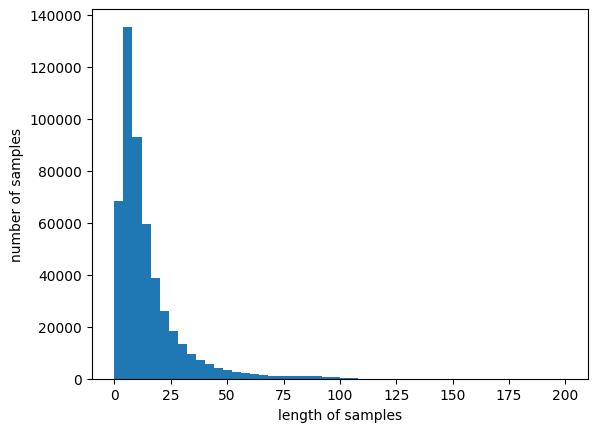

In [48]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data,
                 vector_size = 300, #벡터 차원
                 window = 15,  # 윈도우 크기
                 min_count = 5,  #최소 단어 수
                 workers = 4,  #병렬로 처리하는 데 사용되는 작업자 수
                 sg = 0)

In [50]:
model.wv.vectors.shape


(29379, 300)

In [52]:
print(model.wv.most_similar("최민식"))

[('송강호', 0.8461517095565796), ('류승범', 0.684907853603363), ('전도연', 0.667482316493988), ('조승우', 0.6500550508499146), ('박정민', 0.6457616686820984), ('타짜', 0.6432867050170898), ('박해일', 0.6420919895172119), ('김윤석', 0.6351457834243774), ('김혜수', 0.6168356537818909), ('발연기', 0.6101588606834412)]


In [53]:
print(model.wv.most_similar("지드래곤"))

[('권지용', 0.6465632915496826), ('대마초', 0.6364442110061646), ('정용화', 0.6362272500991821), ('선양', 0.612546443939209), ('국위', 0.6108828783035278), ('대마', 0.6031814813613892), ('병역', 0.6023508310317993), ('공익', 0.5960389375686646), ('미필', 0.5925754904747009), ('특혜', 0.5896546840667725)]


In [54]:
print(model.wv.most_similar("아이유"))

[('윤아', 0.6828092336654663), ('태연', 0.598189651966095), ('지코', 0.5964828729629517), ('장나라', 0.5459984540939331), ('소시', 0.5423093438148499), ('은혁', 0.5253017544746399), ('효연', 0.5186320543289185), ('보아', 0.518040120601654), ('이선균', 0.5170769691467285), ('레벨', 0.5116823315620422)]


In [101]:
print(model.wv.most_similar("대마초"))

[('대마', 0.8689255714416504), ('마약', 0.7537370324134827), ('코카인', 0.7046219110488892), ('엑스터시', 0.6873170733451843), ('씨잼', 0.6646226048469543), ('합법', 0.6633061170578003), ('흡연', 0.6500153541564941), ('지드래곤', 0.6364442110061646), ('불법', 0.6267058849334717), ('반입', 0.6149749159812927)]


In [62]:
print(model.wv.most_similar("트와이스"))

[('블핑', 0.828728973865509), ('걸그룹', 0.7741578817367554), ('레벨', 0.759485125541687), ('모모', 0.7556652426719666), ('소녀시대', 0.7406152486801147), ('아이콘', 0.7246637344360352), ('엑소', 0.7204183340072632), ('랜드', 0.714260995388031), ('멜론', 0.7128980755805969), ('차트', 0.7126613259315491)]


In [102]:
print(model.wv.most_similar("손흥민"))

[('흥민', 0.6392977833747864), ('고윤성', 0.5978349447250366), ('유소영', 0.5912595391273499), ('선수', 0.5807918906211853), ('김연아', 0.5521820783615112), ('기성용', 0.5379868149757385), ('축구', 0.5365874767303467), ('멕시코', 0.5306141376495361), ('지드래곤', 0.5259174704551697), ('조현우', 0.5234219431877136)]


In [67]:
print(model.wv.most_similar("김연아"))

[('박지성', 0.705606997013092), ('손연재', 0.6469093561172485), ('박태환', 0.5941734313964844), ('피겨', 0.562017560005188), ('배구', 0.5579471588134766), ('손흥민', 0.552182137966156), ('축구선수', 0.5467311143875122), ('국빈', 0.536682665348053), ('박기량', 0.5305425524711609), ('김원중', 0.5281070470809937)]


In [107]:
print(model.wv.most_similar("북한"))

[('김정은', 0.8394749760627747), ('북', 0.7675672173500061), ('남한', 0.7517381310462952), ('김일성', 0.7495707273483276), ('남북', 0.747141420841217), ('평화', 0.7457470297813416), ('회담', 0.7382364273071289), ('트럼프', 0.7274119853973389), ('평양', 0.7237446308135986), ('빨갱이', 0.7223802208900452)]


In [105]:
print(model.wv.most_similar("괴물"))

[('인조인간', 0.5599576830863953), ('성형전', 0.5422179102897644), ('오랑우탄', 0.5152392983436584), ('얼굴', 0.5120540261268616), ('원판', 0.5087802410125732), ('성형', 0.4985365867614746), ('입술', 0.4972325563430786), ('마네킹', 0.4919222593307495), ('두껍다', 0.48866790533065796), ('짐승', 0.4886038899421692)]


In [82]:
print(model.wv.most_similar("구글"))

[('최단', 0.5759780406951904), ('유튜브', 0.5697177648544312), ('홈페이지', 0.559505820274353), ('실시간', 0.5588559508323669), ('유료', 0.5583877563476562), ('포털', 0.558098554611206), ('꼴등', 0.5565248131752014), ('파이브', 0.5535078048706055), ('아메리카', 0.5512233972549438), ('포털사이트', 0.5510962605476379)]


In [85]:
print(model.wv.most_similar("유재석"))

[('박명수', 0.7475533485412598), ('정준하', 0.7293365597724915), ('유느님', 0.6958364248275757), ('정형돈', 0.6934395432472229), ('강호동', 0.6901072859764099), ('조세호', 0.6858330368995667), ('무한도전', 0.6841861009597778), ('신동엽', 0.6669977903366089), ('김태호', 0.6618503332138062), ('노홍철', 0.6528859734535217)]


In [86]:
print(model.wv.most_similar("마블"))

[('어벤져스', 0.8181871771812439), ('데드풀', 0.7887707948684692), ('어벤저스', 0.7501022219657898), ('관객', 0.7292365431785583), ('시리즈', 0.7091755270957947), ('이영화', 0.7071725726127625), ('평점', 0.6999680399894714), ('히어로', 0.6997235417366028), ('상영', 0.6864669322967529), ('명량', 0.6816350221633911)]


In [108]:
print(model.wv.most_similar("무한도전"))

[('무도', 0.8336055874824524), ('김태호', 0.7767112851142883), ('정형돈', 0.7247072458267212), ('노홍철', 0.7193962931632996), ('포맷', 0.6963636875152588), ('토토가', 0.6910399198532104), ('나영석', 0.689610481262207), ('유재석', 0.6841861605644226), ('정준하', 0.6811526417732239), ('폐지', 0.6774746179580688)]


In [88]:
print(model.wv.most_similar("올림픽"))

[('평창', 0.7450581192970276), ('폐막식', 0.7322848439216614), ('공연', 0.7091224789619446), ('평창올림픽', 0.7066815495491028), ('북미', 0.7048662304878235), ('평양', 0.689111053943634), ('회담', 0.6847871541976929), ('경기', 0.6748017072677612), ('월드컵', 0.6663774847984314), ('중계', 0.6548246145248413)]


In [89]:
print(model.wv.most_similar("강동원"))

[('원빈', 0.7569830417633057), ('조인성', 0.7091354727745056), ('송승헌', 0.6991796493530273), ('한효주', 0.6874034404754639), ('정우성', 0.6771604418754578), ('장동건', 0.6705188155174255), ('김수현', 0.6442978382110596), ('이정재', 0.6432186961174011), ('송중기', 0.6355583667755127), ('남자배우', 0.6046138405799866)]


In [113]:
print(model.wv.most_similar("음주운전"))

[('음주', 0.8404616117477417), ('마약', 0.7808558344841003), ('뺑소니', 0.7720624208450317), ('전과', 0.6734686493873596), ('심신', 0.6541932821273804), ('도박', 0.6522555351257324), ('미약', 0.647367000579834), ('무면허', 0.6203762888908386), ('폭행', 0.6179825663566589), ('전과자', 0.6122080087661743)]


In [140]:
print(model.wv.most_similar("황정민"))

[('독전', 0.6215618848800659), ('비숲', 0.6170287728309631), ('김동욱', 0.6058598756790161), ('최민식', 0.605168879032135), ('류승범', 0.604802668094635), ('조진웅', 0.6016446948051453), ('송강호', 0.5883671641349792), ('박정민', 0.5881513357162476), ('유영', 0.5780327916145325), ('미스터', 0.575006365776062)]


In [121]:
model

In [128]:
model.wv.save_word2vec_format('./comment_test') #모델저장
loaded_model = KeyedVectors.load_word2vec_format('./comment_test') #모델로드

In [119]:
from gensim.models import Word2Vec
from gensim.scripts import word2vec2tensor
import os

In [116]:
with open('/content/word_embeddings.tsv', 'w', encoding='utf-8') as f:
    for word in model.wv.index_to_key:
        vector = '\t'.join(map(str, model.wv[word]))
        f.write(f'{word}\t{vector}\n')

In [131]:
!python -m gensim.scripts.word2vec2tensor --input comment_test --output comment_test

2023-12-21 19:22:40,917 - word2vec2tensor - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/word2vec2tensor.py --input comment_test --output comment_test
2023-12-21 19:22:40,918 - keyedvectors - INFO - loading projection weights from comment_test
2023-12-21 19:22:48,367 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (29379, 300) matrix of type float32 from comment_test', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-12-21T19:22:48.366039', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-6.1.58+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2023-12-21 19:22:54,446 - word2vec2tensor - INFO - 2D tensor file saved to comment_test_tensor.tsv
2023-12-21 19:22:54,447 - word2vec2tensor - INFO - Tensor metadata file saved to comment_test_metadata.tsv
2023-12-21 19:22:54,450 - word2vec2tensor - INFO - finished running word2vec2tensor.py


In [135]:
from gensim.models import Word2Vec

model2 = Word2Vec(sentences = tokenized_data,
                 vector_size = 300, #벡터 차원
                 window = 20,  # 윈도우 크기
                 min_count = 50,  #최소 단어 수
                 workers = 4,  #병렬로 처리하는 데 사용되는 작업자 수
                 sg = 0)

In [137]:
model2.wv.vectors.shape

(9345, 300)

In [138]:
model.wv.save_word2vec_format('./comment_test2') #모델저장
loaded_model = KeyedVectors.load_word2vec_format('./comment_test2') #모델로드

In [139]:
!python -m gensim.scripts.word2vec2tensor --input comment_test2 --output comment_test2

2023-12-21 19:37:49,267 - word2vec2tensor - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/word2vec2tensor.py --input comment_test2 --output comment_test2
2023-12-21 19:37:49,268 - keyedvectors - INFO - loading projection weights from comment_test2
2023-12-21 19:37:56,773 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (29379, 300) matrix of type float32 from comment_test2', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-12-21T19:37:56.771393', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-6.1.58+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2023-12-21 19:38:03,227 - word2vec2tensor - INFO - 2D tensor file saved to comment_test2_tensor.tsv
2023-12-21 19:38:03,227 - word2vec2tensor - INFO - Tensor metadata file saved to comment_test2_metadata.tsv
2023-12-21 19:38:03,238 - word2vec2tensor - INFO - finished running word2vec2tensor.py
